# **EDA : Exploratory Data Analysis**

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Fake and real news dataset

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 81% 33.0M/41.0M [00:00<00:00, 115MB/s]
100% 41.0M/41.0M [00:00<00:00, 130MB/s]


In [3]:
!unzip fake-and-real-news-dataset

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
import re
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding , LSTM
warnings.filterwarnings('ignore')

In [6]:
real = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv", parse_dates=False)

### **Exploring Real news**

In [7]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
real.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [10]:
print(real["subject"].unique())


['politicsNews' 'worldnews']


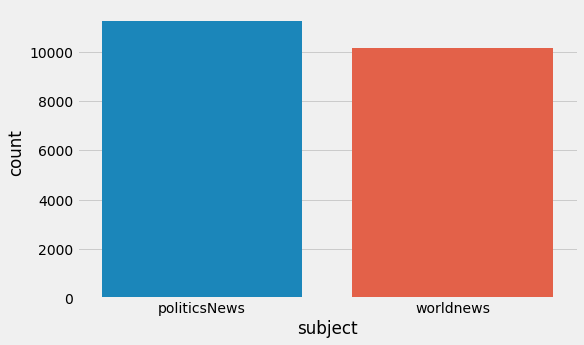

In [11]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=real)
plt.show()

In [12]:
real['year'] = real['date'].str[-5:]

In [13]:
real = real.drop(columns=["date"])

In [14]:
print(real["year"].unique())

['2017 ' '2016 ']


In [15]:
real.head()

,title,text,subject,year
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017


In [16]:
real.groupby("year")["text"].transform("count")

0        16701
1        16701
2        16701
3        16701
4        16701
         ...  
21412    16701
21413    16701
21414    16701
21415    16701
21416    16701
Name: text, Length: 21417, dtype: int64

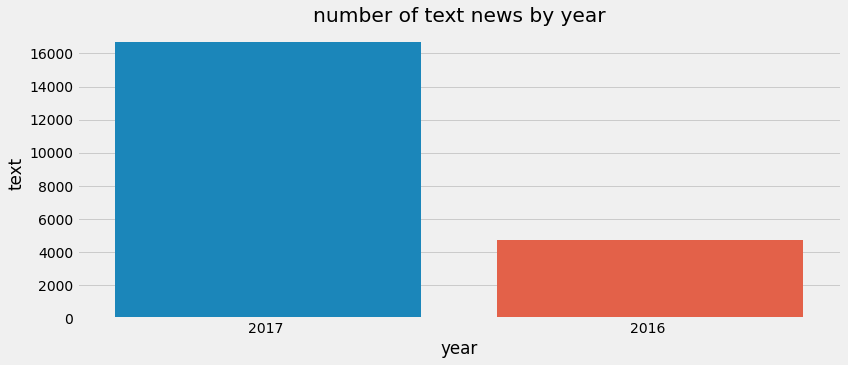

In [17]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x=real['year'], y=real.groupby("year")["text"].transform("count"))
plt.tight_layout()
plt.title('number of text news by year')
plt.show()

In [18]:
df = real.groupby(['year', 'subject']).agg({'text': 'count'})

In [19]:
df = df.reset_index(level=['year', 'subject'])

Text(0.5, 1.0, 'text news by year and by subject')

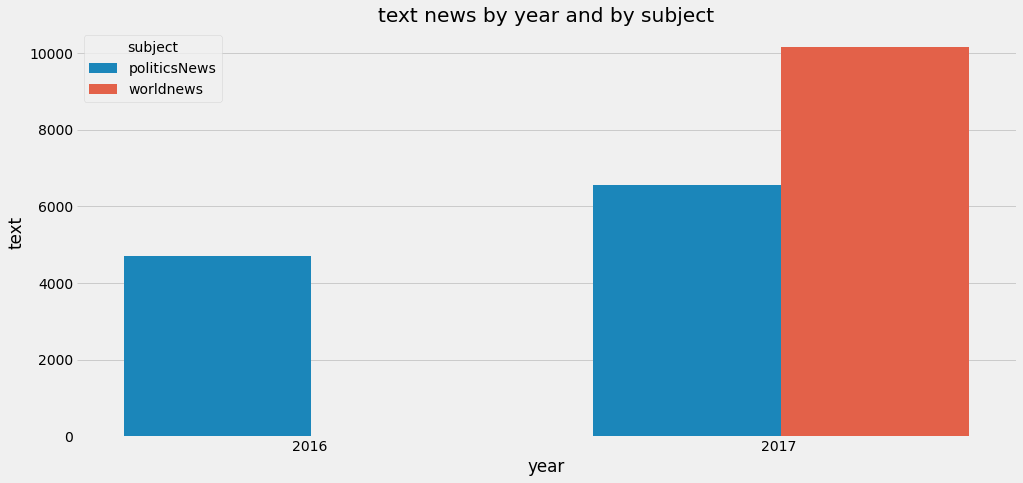

In [20]:
plt.figure(figsize=(15,7))
plt.box(False)
sns.barplot(data=df, x='year', y='text', hue='subject')
plt.title("text news by year and by subject")

In [21]:
# delate empty text 
real.drop(real[real.text.str.isspace()].index, inplace=True)

In [22]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21416 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21416 non-null  object
 1   text     21416 non-null  object
 2   subject  21416 non-null  object
 3   year     21416 non-null  object
dtypes: object(4)
memory usage: 836.6+ KB


In [23]:
# delate publishers from text
real['text'] = real['text'].str.split(r" -").str.get(1)

In [24]:
real.head()

,title,text,subject,year
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,2017
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,2017
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,2017
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,2017
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,2017


In [25]:
# combine title and text columns
real['text'] = real['title'] + " " +real['text']

In [26]:
# Drop the columns "title","subject","year"
real = real.drop(columns=["title","subject","year"])

In [27]:
real["class"] = 1

In [28]:
real.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


### **Exploring Fake News**

In [29]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [30]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [31]:
print(fake["subject"].unique())

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


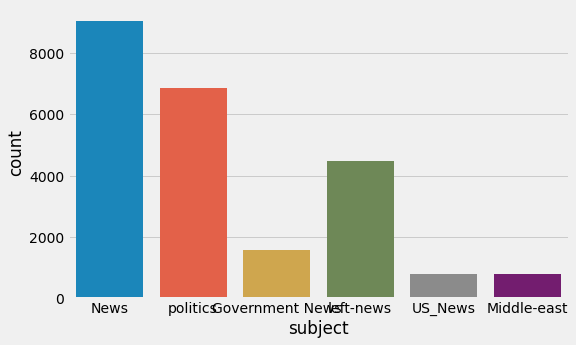

In [32]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake)
plt.show()

In [33]:
fake['year'] = fake['date'].str[-4:]

In [34]:
fake = fake.drop(columns=["date"])

In [35]:
fake['year'] = fake[fake.year.apply(lambda x: x.isnumeric())]['year']

In [36]:
fake.dropna(subset = ["year"], inplace=True)

In [37]:
print(fake["year"].unique())

['2017' '2016' '2015']


In [38]:
fake.groupby("year")["text"].transform("count")

0         9203
1         9203
2         9203
3         9203
4         9203
         ...  
23476    11754
23477    11754
23478    11754
23479    11754
23480    11754
Name: text, Length: 23436, dtype: int64

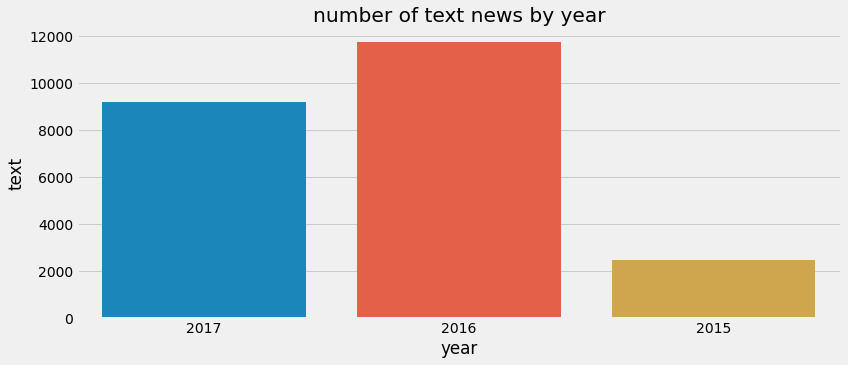

In [39]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x=fake['year'], y=fake.groupby("year")["text"].transform("count"))
plt.tight_layout()
plt.title('number of text news by year')
plt.show()

In [40]:
df = fake.groupby(['year', 'subject']).agg({'text': 'count'})

In [41]:
df = df.reset_index(level=['year', 'subject'])

Text(0.5, 1.0, 'text news by year and by subject')

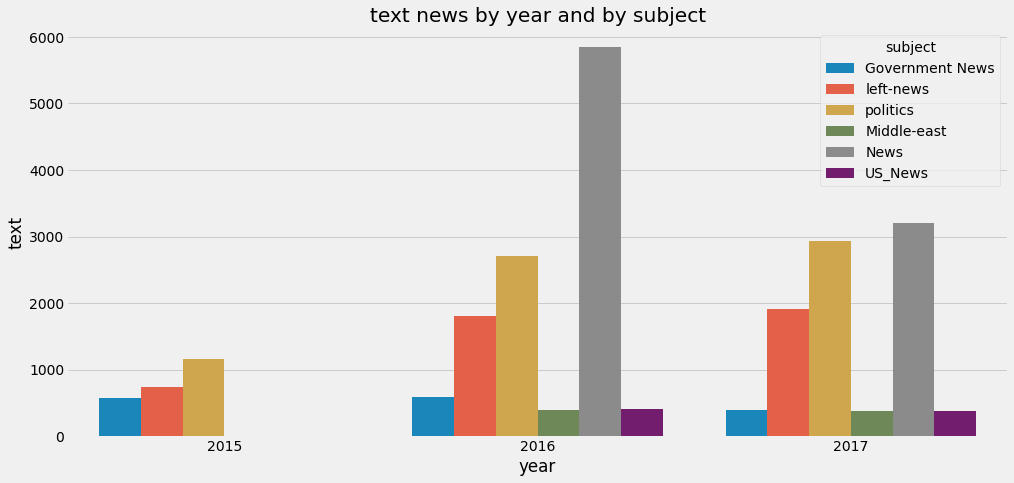

In [42]:
plt.figure(figsize=(15,7))
plt.box(False)
sns.barplot(data=df, x='year', y='text', hue='subject')
plt.title("text news by year and by subject")

In [43]:
# delate empty text 
fake.drop(fake[fake.text.str.isspace()].index, inplace=True)

In [44]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22806 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    22806 non-null  object
 1   text     22806 non-null  object
 2   subject  22806 non-null  object
 3   year     22806 non-null  object
dtypes: object(4)
memory usage: 890.9+ KB


In [45]:
# combine title and text columns
fake['text'] = fake['title'] + " " +fake['text']

In [46]:
# Drop the columns "title","subject","year"
fake = fake.drop(columns=["title","subject","year"])

In [47]:
fake["class"] = 0

In [48]:
fake.head()

,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


**concatenate two dataframes**

In [49]:
data = pd.concat([real,fake],ignore_index=False)

In [50]:
data.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44222 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44202 non-null  object
 1   class   44222 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [52]:
data.to_csv('out.csv',index=False)

In [55]:
del real,fake

In [53]:
df = pd.read_csv("out.csv")

In [54]:
df.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [61]:
df['text']=df['text'].astype(str)

In [62]:
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [63]:
df.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


In [122]:
max_fatures = 3000
max_length = 50
dropout_rate = 0.5
no_epochs = 5
batch_size = 64

In [97]:
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=max_length)

In [98]:
Y = df['class'].values

In [124]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1,test_size=0.20,stratify=Y)

In [125]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(35377, 50) (35377,)
(8845, 50) (8845,)


In [105]:
# Design Neural Network Architecture with SimpleRNN
print('Building Simple RNN Model..')

RNN_model = Sequential()
# Add Embedding layer
RNN_model.add(Embedding(max_fatures, 64, input_length=max_length))
RNN_model.add(Dropout(dropout_rate))
# Add Simple RNN layer
RNN_model.add(LSTM(units = 64 , dropout=0.2, recurrent_dropout=0.2, input_shape=(100, 64)))
# Add Dense Hidden Layer
RNN_model.add(Dense(256, activation='relu'))
RNN_model.add(Dropout(dropout_rate))
RNN_model.add(Dense(128, activation='relu'))
RNN_model.add(Dropout(dropout_rate))
# Output Layer 
RNN_model.add(Dense(1, activation='sigmoid'))

Building Simple RNN Model..


In [106]:
RNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 64)            192000    
                                                                 
 dropout_9 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_9 (Dense)             (None, 256)               16640     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)              

In [109]:
# Configure model
RNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [123]:
# Train!
print('Training the model..')
history = RNN_model.fit(X_train, y_train, batch_size=batch_size, verbose=2, epochs=no_epochs,validation_split=.3)


Training the model..
Epoch 1/5
310/310 - 40s - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.2284 - val_accuracy: 0.9611 - 40s/epoch - 128ms/step
Epoch 2/5
310/310 - 30s - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.2389 - val_accuracy: 0.9647 - 30s/epoch - 97ms/step
Epoch 3/5
310/310 - 30s - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.1672 - val_accuracy: 0.9700 - 30s/epoch - 98ms/step
Epoch 4/5
310/310 - 31s - loss: 0.0075 - accuracy: 0.9968 - val_loss: 0.2478 - val_accuracy: 0.9679 - 31s/epoch - 101ms/step
Epoch 5/5
310/310 - 30s - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.2554 - val_accuracy: 0.9647 - 30s/epoch - 97ms/step


In [126]:
# evaluate the classification model
_,acc = RNN_model.evaluate(X_test, y_test)
print("acc: %.2f" % (acc))

277/277 [==============================] - 5s 17ms/step - loss: 0.2865 - accuracy: 0.9636
acc: 0.96


In [127]:
# confusion matrix
y_pred = RNN_model.predict(X_test,batch_size=1,verbose = 2)
y_pred = np.where(y_pred < 0.5, 0, 1)
matrix = metrics.confusion_matrix(y_pred,y_test)
print(matrix)

8845/8845 - 53s - 53s/epoch - 6ms/step
[[4428  188]
 [ 134 4095]]


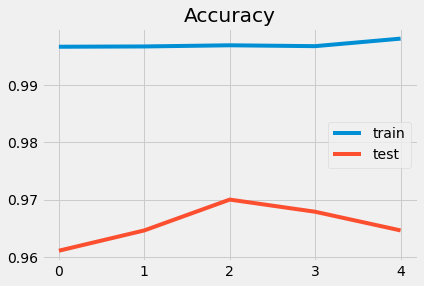

In [129]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();